In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

# Globally setting print options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [ ]:
users = pd.read_csv('/content/drive/MyDrive/BX-Users.csv', on_bad_lines='skip', delimiter=';', encoding = 'ISO-8859-1') #encoding = "latin-1"

In [ ]:
books = pd.read_csv('/content/drive/MyDrive/BX-Books.csv', on_bad_lines='skip', delimiter=';', encoding = 'ISO-8859-1') #encoding = "latin-1

<ipython-input-5-e4402a19d355>:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books = pd.read_csv('/content/drive/MyDrive/BX-Books.csv', on_bad_lines='skip', delimiter=';', encoding = 'ISO-8859-1') #encoding = "latin-1


In [ ]:
ratings = pd.read_csv('/content/drive/MyDrive/BX-Book-Ratings.csv', on_bad_lines='skip', delimiter=';', encoding = 'ISO-8859-1')

In [ ]:
users.shape

(278858, 3)

In [ ]:
users.columns

Index(['User-ID', 'Location', 'Age'], dtype='object')

In [ ]:
books.shape

(271360, 8)

In [ ]:
books.columns

Index(['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher',
       'Image-URL-S', 'Image-URL-M', 'Image-URL-L'],
      dtype='object')

In [ ]:
ratings.shape

(1149780, 3)

In [ ]:
ratings.columns

Index(['User-ID', 'ISBN', 'Book-Rating'], dtype='object')

### Merge .csv files

In [ ]:
data = pd.merge(ratings, users, on='User-ID', how='inner')

In [ ]:
data = pd.merge(data, books, on='ISBN', how='inner')

In [ ]:
data.head()

,User-ID,ISBN,Book-Rating,Location,Age,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,276725,034545104X,0,"tyler, texas, usa",NaN,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
1,2313,034545104X,5,"cincinnati, ohio, usa",23.0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
2,6543,034545104X,0,"strafford, missouri, usa",34.0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
3,8680,034545104X,5,"st. charles county, missouri, usa",2.0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
4,10314,034545104X,9,"beaverton, oregon, usa",NaN,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...


In [ ]:
data.shape

(1031136, 12)

In [ ]:
data.columns

Index(['User-ID', 'ISBN', 'Book-Rating', 'Location', 'Age', 'Book-Title',
       'Book-Author', 'Year-Of-Publication', 'Publisher', 'Image-URL-S',
       'Image-URL-M', 'Image-URL-L'],
      dtype='object')

### Drop unnecessary columns

In [ ]:
df = data.drop(columns=['Image-URL-S', 'Image-URL-M', 'Image-URL-L'], axis=1)

In [ ]:
df.shape

(1031136, 9)

### Feature Extraction

In [ ]:
# Extract country from Location column
# Drop Location column

df['Country'] = df['Location'].str.split(',').str[-1].str.strip()
df.drop(columns=['Location'], inplace=True)

### Data Wrangling

In [ ]:
# Change data type of year column
# Year-Of-Publication has non-numeric values. errors='coerce' - replace non-numeric values with NaN

df['Year-Of-Publication'] = pd.to_numeric(df['Year-Of-Publication'], errors='coerce')

In [ ]:
# Move target column 'Book-Rating' as the last column in the df

move_target = 'Book-Rating'
df = df[[col for col in df.columns if col!= move_target] + [move_target]]

In [ ]:
df.head()

,User-ID,ISBN,Age,Book-Title,Book-Author,Year-Of-Publication,Publisher,Country,Book-Rating
0,276725,034545104X,NaN,Flesh Tones: A Novel,M. J. Rose,2002.0,Ballantine Books,usa,0
1,2313,034545104X,23.0,Flesh Tones: A Novel,M. J. Rose,2002.0,Ballantine Books,usa,5
2,6543,034545104X,34.0,Flesh Tones: A Novel,M. J. Rose,2002.0,Ballantine Books,usa,0
3,8680,034545104X,2.0,Flesh Tones: A Novel,M. J. Rose,2002.0,Ballantine Books,usa,5
4,10314,034545104X,NaN,Flesh Tones: A Novel,M. J. Rose,2002.0,Ballantine Books,usa,9


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1031136 entries, 0 to 1031135
Data columns (total 9 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   User-ID              1031136 non-null  int64  
 1   ISBN                 1031136 non-null  object 
 2   Age                  753301 non-null   float64
 3   Book-Title           1031136 non-null  object 
 4   Book-Author          1031135 non-null  object 
 5   Year-Of-Publication  1031132 non-null  float64
 6   Publisher            1031134 non-null  object 
 7   Country              1031136 non-null  object 
 8   Book-Rating          1031136 non-null  int64  
dtypes: float64(2), int64(2), object(5)
memory usage: 78.7+ MB


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
User-ID,1031136.0,140594.503506,80524.659039,2.0,70415.0,141210.0,211426.0,278854.0
Age,753301.0,37.397648,14.098254,0.0,28.0,35.0,45.0,244.0
Year-Of-Publication,1031132.0,1968.194915,231.101484,0.0,1992.0,1997.0,2001.0,2050.0
Book-Rating,1031136.0,2.839051,3.854157,0.0,0.0,0.0,7.0,10.0


Age has a minimum value of 0 and maximum of 244 indicating the presence of outliers.

### Outlier Treatment for Age using IQR Method

<ipython-input-29-b974e9590443>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Age'], kde=False)


<Axes: xlabel='Age'>

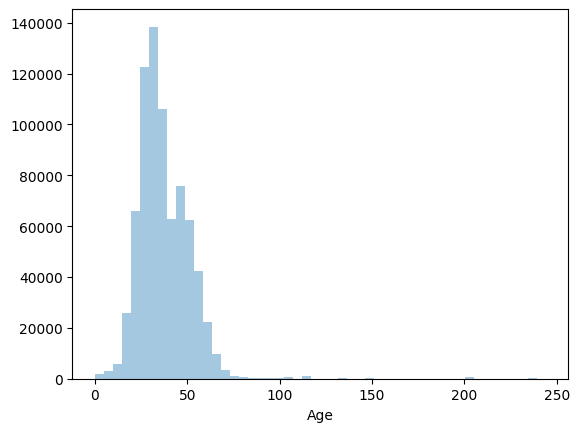

In [ ]:
import seaborn as sns

# Distribution for Age

sns.distplot(df['Age'], kde=False)

<Axes: >

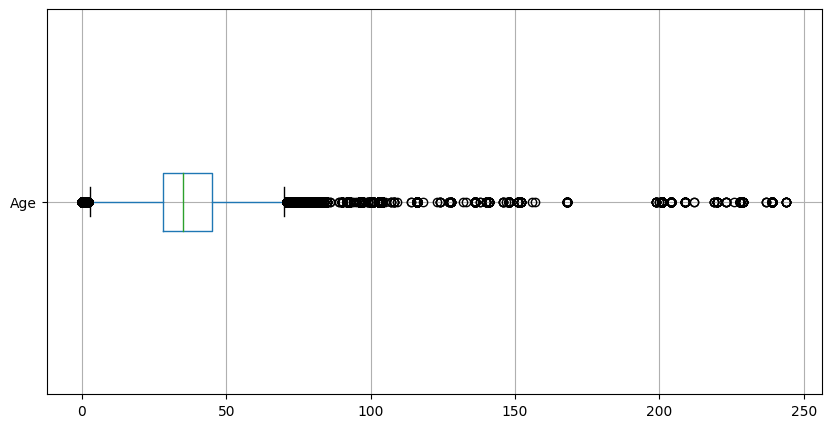

In [ ]:
# Boxplot for Age

import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
df.boxplot('Age', vert=False)

In [ ]:
"""
Function iterates over a list of numeric columns and calculates the quantiles, IQR and upper and lower limits
"""

def calculate_iqr_limits(df, cols):
  iqr_limits_dict = {}
  for col in cols:
    # min and max
    min = df[col].min()
    max = df[col].max()

    # Quantiles
    Q1 = df[col].quantile(0.25)
    Q2 = df[col].quantile(0.5) # median
    Q3 = df[col].quantile(0.75)

    # IQR range
    IQR = round((Q3 - Q1),2)

    # upper and lower limits
    lower_iqr_limit = round((Q1 - (1.5*IQR)),2)
    upper_iqr_limit = round((Q3 + (1.5*IQR)),2)

    iqr_limits_dict[col] = {'IQR':IQR, 'min': min, 'LowerLimit':lower_iqr_limit, 'Q1':Q1, 'Q2':Q2, 'Q3':Q3, 'max': max, 'UpperLimit':upper_iqr_limit}

  return iqr_limits_dict

In [ ]:
"""
Function iterates over a list of numerical columns and checks and prints outliers based on the IQR calculation perfomed above
"""

def print_outliers(df, iqr_limit_dict):
  outliers_dict = {}
  outliers_total_count = 0
  rows_w_ouliers = set() # if multiple outliers found at the same row index, the row index will only be appended once

  for col, iqr_limits in iqr_limit_dict.items():
    # Get outliers in the column
    outliers_series = df[(df[col] < iqr_limits['LowerLimit']) | (df[col] > iqr_limits['UpperLimit'])][col]

    if not outliers_series.empty:
      outliers_tuple = [(index, value) for index, value in outliers_series.iteritems()]
      outliers_dict[col] = outliers_tuple

    # Get the count of outliers in the column
    outliers_count = len(outliers_series)
    outliers_total_count += outliers_count

    if outliers_count > 0:
      rows_w_ouliers.update(outliers_series.index)
      print(f'Outliers for column {col}:')
      print(outliers_series)
      print(f'Count of outliers in {col}: {outliers_count} \n')

  print(f'Total count of outliers: {outliers_total_count}')
  print(f'Count of rows with at least one outlier: {len(rows_w_ouliers)}')

In [ ]:
numeric_col = ['Age']

In [ ]:
calculated_limits_dict = calculate_iqr_limits(df, numeric_col)
calculated_limits_dict

{'Age': {'IQR': 17.0,
  'min': 0.0,
  'LowerLimit': 2.5,
  'Q1': 28.0,
  'Q2': 35.0,
  'Q3': 45.0,
  'max': 244.0,
  'UpperLimit': 70.5}}

In [ ]:
# Get the values between upper limit and maximum for Car_Age
condition_Age = df[(df['Age'] >= 0) & (df['Age'] < 2.5) | (df['Age'] > 70.5) & (df['Age'] <= 244)]['Age']

# Sort and get the unique value
sorted_values_Car_Age = condition_Age.sort_values().unique()
sorted_values_Car_Age

array([  0.,   1.,   2.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,  78.,
        79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  89.,  90.,  92.,
        93.,  94.,  95.,  96.,  97.,  98.,  99., 100., 101., 103., 104.,
       105., 107., 108., 109., 114., 116., 118., 123., 124., 127., 128.,
       132., 133., 136., 138., 140., 141., 146., 147., 148., 151., 152.,
       156., 157., 168., 199., 200., 201., 204., 209., 212., 219., 220.,
       223., 226., 228., 229., 237., 239., 244.])

In [ ]:
# Drop outlier values for Age column - 7,970 records dropped

age_ouliers_condition = ((df['Age'] >= 0) & (df['Age'] < 2.5)) | ((df['Age'] > 70.5) & (df['Age'] <= 244))

df = df.drop(df[age_ouliers_condition].index)
df.reset_index(drop=True, inplace=True)

df.shape

(1023166, 9)

<ipython-input-37-fe5028fe1da6>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Age'], kde=False)


<Axes: xlabel='Age'>

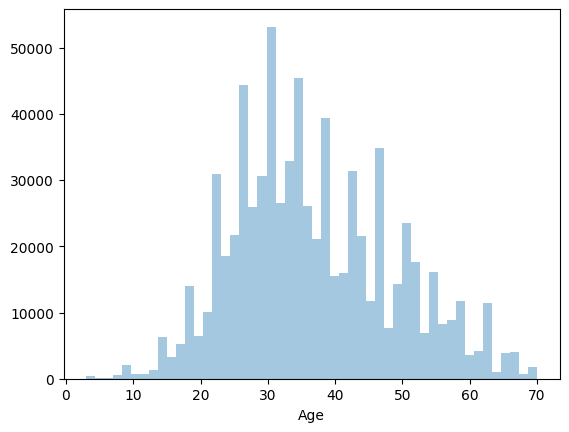

In [ ]:
# Distribution for Age after outlier treatment

sns.distplot(df['Age'], kde=False)

<Axes: >

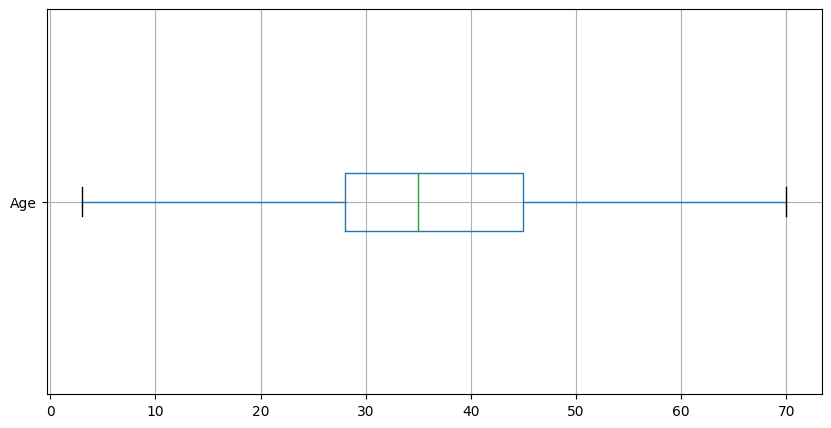

In [ ]:
# Boxplot for Age after outlier treatment

import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
df.boxplot('Age', vert=False)

### Missing Value Imputation

In [ ]:
"""
Function to get the columns with missing values and their percentages alone
"""

def get_missing_val_count_df(df):
    missing_values = df.isnull().sum()
    missing_df = pd.DataFrame({'Feature_with_missing_value': missing_values.index, 'Missing_values': missing_values.values,
                               'Percentage_missing_values': (missing_values.values/len(df))*100})
    return missing_df[missing_df['Missing_values'] > 0]

In [ ]:
get_missing_val_count_df(df)

,Feature_with_missing_value,Missing_values,Percentage_missing_values
2,Age,277835,27.154440
4,Book-Author,1,0.000098
5,Year-Of-Publication,4,0.000391
6,Publisher,2,0.000195


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
User-ID,1023166.0,140585.933554,80497.344960,2.0,70401.0,141203.0,211426.0,278854.0
Age,745331.0,36.853182,11.812047,3.0,28.0,35.0,45.0,70.0
Year-Of-Publication,1023162.0,1968.255688,230.849785,0.0,1992.0,1997.0,2001.0,2050.0
Book-Rating,1023166.0,2.836635,3.853639,0.0,0.0,0.0,7.0,10.0


In [ ]:
# Mean chosen for Age missing value imputation, as mean (36.8) and median (35) are close enough

df['Age'] = df['Age'].fillna(df['Age'].median())

In [ ]:
# Drop rows iwth null values for 'Book-Author', 'Publisher' and 'Year-Of-Publication'

columns_to_drop = ['Book-Author', 'Publisher', 'Year-Of-Publication']
df.dropna(subset=columns_to_drop, inplace=True)

In [ ]:
get_missing_val_count_df(df)

,Feature_with_missing_value,Missing_values,Percentage_missing_values


### MISC

In [ ]:
df['Country'] = df['Country'].str.strip('"')

In [ ]:
df['Country'].value_counts()

usa                 740674
canada               92426
united kingdom       32935
germany              27457
                     23806
                     ...  
onondaga nation          1
kosovo                   1
richmond country         1
angola                   1
maracopa                 1
Name: Country, Length: 258, dtype: int64

In [ ]:
usa_mapping = {
    'usa': 'united states',
    'u.s.a': 'united states',
    'u.s.a.': 'united states',
    'us': 'united states',
    'united states' : 'united states',
    'united state' :'united states',
    'u.s>' : 'united states',
    'u.s.a>' : 'united states',
    'united staes' :  'united states',
    'united states of america' : 'united states',
    'u.s. of a.' : 'united states',
    'united sates' : 'united states'
}

# Replace variations with the standardized value
df['Country'] = df['Country'].replace(usa_mapping)

In [ ]:
uk_mapping = {
    'united kingdom' : 'united kingdom',
    'united kindgonm' : 'united kingdom',
    'u.k.' : 'united kingdom',
    'united kingdom"' : 'united kingdom'
}

# Replace variations with the standardized value
df['Country'] = df['Country'].replace(uk_mapping)

In [ ]:
uae_mapping = {
    'united arab emirates' : 'united arab emirates',
    'u.a.e.' : 'united arab emirates',
    'u.a.e' : 'united arab emirates',
}

# Replace variations with the standardized value
df['Country'] = df['Country'].replace(uae_mapping)

In [ ]:
catalonia_mapping = {
    'catalonia' : 'catalonia',
    'catalunya' : 'catalonia'
}

# Replace variations with the standardized value
df['Country'] = df['Country'].replace(catalonia_mapping)

In [ ]:
uruguay_mapping = {
    'uruguay' : 'uruguay',
    'urugua' : 'uruguay'
}

# Replace variations with the standardized value
df['Country'] = df['Country'].replace(uruguay_mapping)

In [ ]:
spain_mapping = {
    'españa' : 'spain',
    'spain' : 'spain'
}

# Replace variations with the standardized value
df['Country'] = df['Country'].replace(spain_mapping)

In [ ]:
basque_mapping = {
    'euskal herria ' : 'basque'
}

# Replace variations with the standardized value
df['Country'] = df['Country'].replace(basque_mapping)

In [ ]:
italy_mapping = {
    'italia' : 'italy',
    'italy' : 'italy'
}

# Replace variations with the standardized value
df['Country'] = df['Country'].replace(italy_mapping)

In [ ]:
p_mapping = {
    'phillipines' : 'philippines',
    'philippines' : 'philippines'
}

# Replace variations with the standardized value
df['Country'] = df['Country'].replace(p_mapping)

In [ ]:
tt_mapping = {
    'tobago' : 'trinidad and tobago',
    'trinidad and tobago' : 'trinidad and tobago'
}

# Replace variations with the standardized value
df['Country'] = df['Country'].replace(tt_mapping)

In [ ]:
values_to_drop = ['universe', 'n/a', 'unknown', 'n/a - on the road', 'lkjlj', 'c', 'far away...', 'la chine éternelle !',
                  'the great white north', 'we`re global!', 'ee.uu', 'usa & canada', 'usa (currently living in england)',
                  'ua','"', 'everywhere and anywhere']

# Drop rows with the specified values
df = df[~df['Country'].isin(values_to_drop)].reset_index(drop=True)

In [ ]:
# Count occurrences of each country
country_counts = df['Country'].value_counts()

# Create a boolean mask for countries with count < 10
mask = df['Country'].isin(country_counts[country_counts >= 10].index)

# Filter out rows with countries having count < 10
df = df[mask]

In [ ]:
df.shape

(1011351, 9)

In [ ]:
df = df[df['Country'].str.strip() != ''].reset_index(drop=True)

In [ ]:
df['Country'].value_counts()

united states     741248
canada             92426
united kingdom     32949
germany            27457
australia          17961
                   ...  
albania               10
moldova               10
honduras              10
framingham            10
colombia              10
Name: Country, Length: 99, dtype: int64

In [ ]:
df['Book-Title'].value_counts()

Wild Animus                                                                    2434
The Lovely Bones: A Novel                                                      1217
The Da Vinci Code                                                               870
A Painted House                                                                 798
The Nanny Diaries: A Novel                                                      795
                                                                               ... 
The Illustrated Guide to Celtic Mythology                                         1
Annotated Huckleberry Finn                                                        1
Facts of Love                                                                     1
The Creative Lunch Box: Easy, Nutritious, and Inviting Meals for Your Child       1
Perplexing Lateral Thinking Puzzles: Scholastic Edition                           1
Name: Book-Title, Length: 237445, dtype: int64

In [ ]:
df['Year-Of-Publication'] = df['Year-Of-Publication'].astype(int)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 987545 entries, 0 to 987544
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   User-ID              987545 non-null  int64  
 1   ISBN                 987545 non-null  object 
 2   Age                  987545 non-null  float64
 3   Book-Title           987545 non-null  object 
 4   Book-Author          987545 non-null  object 
 5   Year-Of-Publication  987545 non-null  int64  
 6   Publisher            987545 non-null  object 
 7   Country              987545 non-null  object 
 8   Book-Rating          987545 non-null  int64  
dtypes: float64(1), int64(3), object(5)
memory usage: 67.8+ MB


### Feature Encoding

In [ ]:
df.head(5)

,User-ID,ISBN,Age,Book-Title,Book-Author,Year-Of-Publication,Publisher,Country,Book-Rating
0,276725,034545104X,35.0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,united states,0
1,2313,034545104X,23.0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,united states,5
2,6543,034545104X,34.0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,united states,0
3,10314,034545104X,35.0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,united states,9
4,23768,034545104X,45.0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,united states,0


In [ ]:
df['Year-Of-Publication'].value_counts()

2002    87534
2001    76336
1999    71938
2003    69298
2000    69064
        ...  
2008        1
2012        1
1904        1
1378        1
1910        1
Name: Year-Of-Publication, Length: 116, dtype: int64

In [ ]:
label_encoder = LabelEncoder()
for col in ['User-ID', 'ISBN', 'Book-Title', 'Book-Author', 'Publisher', 'Country', 'Year-Of-Publication']:
    df[col] = label_encoder.fit_transform(df[col])

In [ ]:
df.head(5)

,User-ID,ISBN,Age,Book-Title,Book-Author,Year-Of-Publication,Publisher,Country,Book-Rating
0,87368,45248,35.0,66738,60689,99,1368,94,0
1,684,45248,23.0,66738,60689,99,1368,94,5
2,1948,45248,34.0,66738,60689,99,1368,94,0
3,3057,45248,35.0,66738,60689,99,1368,94,9
4,7217,45248,45.0,66738,60689,99,1368,94,0


In [ ]:
# Define embedding sizes
categorical_columns = ['User-ID', 'ISBN', 'Book-Title', 'Book-Author', 'Publisher', 'Country', 'Year-Of-Publication']

embedding_sizes = [
    (len(df['User-ID'].unique()), 10),  # Embedding for User-ID
    (len(df['ISBN'].unique()), 10),      # Embedding for ISBN
    (len(df['Book-Title'].unique()), 10), # Embedding for Book-Title
    (len(df['Book-Author'].unique()), 10), # Embedding for Book-Author
    (len(df['Publisher'].unique()), 10),  # Embedding for Publisher
    (len(df['Country'].unique()), 10),     # Embedding for Country
    (len(df['Year-Of-Publication'].unique()), 10) # Embedding for Year-Of-Publication
]

In [ ]:
# Create embedding layers
embedding_layers = nn.ModuleList([nn.Embedding(num_embeddings, embedding_dim) for num_embeddings, embedding_dim in embedding_sizes])

In [ ]:
# Convert categorical columns to tensor and apply embedding
categorical_columns = ['User-ID', 'ISBN', 'Book-Title', 'Book-Author', 'Publisher', 'Country', 'Year-Of-Publication']
embeddings = []
for i, col in enumerate(categorical_columns):
    col_tensor = torch.tensor(df[col].astype('category').cat.codes.values, dtype=torch.long)
    embedding = embedding_layers[i](col_tensor)
    embeddings.append(embedding)

In [ ]:
# Concatenate embeddings
concatenated_embeddings = torch.cat(embeddings, dim=1)

In [ ]:
other_columns = ['Age']
other_data = torch.tensor(df[other_columns].values, dtype=torch.float)

# Target variable
target_variable = torch.tensor(df['Book-Rating'].values, dtype=torch.float).view(-1, 1)

# Concatenate all tensors
final_data = torch.cat([concatenated_embeddings, other_data, target_variable], dim=1)

# Convert tensor to DataFrame
final_df = pd.DataFrame(final_data.detach().numpy())
# print(final_df)

In [ ]:
df.shape

(987545, 9)

In [ ]:
final_df.shape

(987545, 72)

In [ ]:
final_df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
0,0.746168,-0.810655,0.888104,2.468830,2.514991,-1.067176,-1.606156,0.074390,-0.818922,-1.121221,...,-0.835111,0.272235,0.622471,-1.700499,-0.654456,-0.80443,-0.970679,0.659021,35.0,0.0
1,-1.103855,0.819487,-0.099453,0.621411,0.436175,-1.238199,-2.815531,-1.289230,-0.615136,1.023094,...,-0.835111,0.272235,0.622471,-1.700499,-0.654456,-0.80443,-0.970679,0.659021,23.0,5.0
2,0.287831,-0.094337,1.711239,1.176222,-0.670765,0.688797,1.268980,0.589267,-0.678166,-0.537350,...,-0.835111,0.272235,0.622471,-1.700499,-0.654456,-0.80443,-0.970679,0.659021,34.0,0.0
3,0.327290,0.492484,-0.108767,-0.413331,-0.323997,-0.059049,0.420389,-2.434185,-1.371537,0.182179,...,-0.835111,0.272235,0.622471,-1.700499,-0.654456,-0.80443,-0.970679,0.659021,35.0,9.0
4,-1.876243,0.585317,0.364692,-0.301256,0.943233,-0.211280,-1.702573,-0.156380,-0.075577,1.255204,...,-0.835111,0.272235,0.622471,-1.700499,-0.654456,-0.80443,-0.970679,0.659021,45.0,0.0


In [ ]:
# Wide part: 'Publisher' and 'Country' columns
wide_df = final_df.iloc[:, 40:60]  # Assuming column indices 1 and 6 correspond to 'ISBN' and 'Country'

# Deep part: Columns from index 20 to index 39 and from index 60 to index 70
deep_df = final_df.iloc[:, 20:40].copy()  # Selects columns from index 20 to index 39 inclusive
deep_df = pd.concat([deep_df, final_df.iloc[:, 60:72]], axis=1 )

# Cross-transformation part: 'User-ID' and 'ISBN' columns
cross_df = final_df.iloc[:, 0:20]

In [ ]:
wide_df.head(5)

,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59
0,1.528248,-0.481544,-0.714819,-0.48865,-0.131541,-0.651028,1.841544,0.760279,-0.286164,0.571462,-0.701666,1.322278,-0.902065,0.16018,1.356383,0.184868,0.150181,-0.64582,-0.369945,2.178946
1,1.528248,-0.481544,-0.714819,-0.48865,-0.131541,-0.651028,1.841544,0.760279,-0.286164,0.571462,-0.701666,1.322278,-0.902065,0.16018,1.356383,0.184868,0.150181,-0.64582,-0.369945,2.178946
2,1.528248,-0.481544,-0.714819,-0.48865,-0.131541,-0.651028,1.841544,0.760279,-0.286164,0.571462,-0.701666,1.322278,-0.902065,0.16018,1.356383,0.184868,0.150181,-0.64582,-0.369945,2.178946
3,1.528248,-0.481544,-0.714819,-0.48865,-0.131541,-0.651028,1.841544,0.760279,-0.286164,0.571462,-0.701666,1.322278,-0.902065,0.16018,1.356383,0.184868,0.150181,-0.64582,-0.369945,2.178946
4,1.528248,-0.481544,-0.714819,-0.48865,-0.131541,-0.651028,1.841544,0.760279,-0.286164,0.571462,-0.701666,1.322278,-0.902065,0.16018,1.356383,0.184868,0.150181,-0.64582,-0.369945,2.178946


In [ ]:
deep_df.head(5)

,20,21,22,23,24,25,26,27,28,29,...,62,63,64,65,66,67,68,69,70,71
0,0.813798,-1.472881,-1.467341,-1.042885,-1.759362,-1.454314,0.441501,-0.61647,0.216983,-0.207966,...,-0.835111,0.272235,0.622471,-1.700499,-0.654456,-0.80443,-0.970679,0.659021,35.0,0.0
1,0.813798,-1.472881,-1.467341,-1.042885,-1.759362,-1.454314,0.441501,-0.61647,0.216983,-0.207966,...,-0.835111,0.272235,0.622471,-1.700499,-0.654456,-0.80443,-0.970679,0.659021,23.0,5.0
2,0.813798,-1.472881,-1.467341,-1.042885,-1.759362,-1.454314,0.441501,-0.61647,0.216983,-0.207966,...,-0.835111,0.272235,0.622471,-1.700499,-0.654456,-0.80443,-0.970679,0.659021,34.0,0.0
3,0.813798,-1.472881,-1.467341,-1.042885,-1.759362,-1.454314,0.441501,-0.61647,0.216983,-0.207966,...,-0.835111,0.272235,0.622471,-1.700499,-0.654456,-0.80443,-0.970679,0.659021,35.0,9.0
4,0.813798,-1.472881,-1.467341,-1.042885,-1.759362,-1.454314,0.441501,-0.61647,0.216983,-0.207966,...,-0.835111,0.272235,0.622471,-1.700499,-0.654456,-0.80443,-0.970679,0.659021,45.0,0.0


In [ ]:
cross_df.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.746168,-0.810655,0.888104,2.468830,2.514991,-1.067176,-1.606156,0.074390,-0.818922,-1.121221,-1.914329,-1.134243,-0.846846,-0.869771,-3.657259,1.031272,-1.036156,-0.934281,-0.641291,0.688413
1,-1.103855,0.819487,-0.099453,0.621411,0.436175,-1.238199,-2.815531,-1.289230,-0.615136,1.023094,-1.914329,-1.134243,-0.846846,-0.869771,-3.657259,1.031272,-1.036156,-0.934281,-0.641291,0.688413
2,0.287831,-0.094337,1.711239,1.176222,-0.670765,0.688797,1.268980,0.589267,-0.678166,-0.537350,-1.914329,-1.134243,-0.846846,-0.869771,-3.657259,1.031272,-1.036156,-0.934281,-0.641291,0.688413
3,0.327290,0.492484,-0.108767,-0.413331,-0.323997,-0.059049,0.420389,-2.434185,-1.371537,0.182179,-1.914329,-1.134243,-0.846846,-0.869771,-3.657259,1.031272,-1.036156,-0.934281,-0.641291,0.688413
4,-1.876243,0.585317,0.364692,-0.301256,0.943233,-0.211280,-1.702573,-0.156380,-0.075577,1.255204,-1.914329,-1.134243,-0.846846,-0.869771,-3.657259,1.031272,-1.036156,-0.934281,-0.641291,0.688413


In [ ]:
deep_df.shape

(987545, 32)

In [ ]:
wide_cross_df = pd.concat([wide_df, cross_df], axis=1)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np


class WideModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(WideModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)


class DeepModel(nn.Module):
    def __init__(self, input_size_deep, output_size_deep):
        super(DeepModel, self).__init__()
        self.fc1 = nn.Linear(input_size_deep, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, output_size_deep)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [ ]:
# Extract target values from deep_df based on column index
target_tensor = torch.tensor(deep_df.iloc[:, 31].values, dtype=torch.float32)

In [ ]:
target_tensor

tensor([0., 5., 0.,  ..., 0., 0., 5.])

In [ ]:
# Assuming wide_cross_df and deep_df are your DataFrames containing PyTorch tensors
import pandas as pd

# Access PyTorch tensors from DataFrames
wide_cross_tensor = wide_cross_df.values
deep_tensor = deep_df.values

In [ ]:
import torch

# Convert NumPy arrays to PyTorch tensors
wide_cross_tensor = torch.tensor(wide_cross_tensor)
deep_tensor = torch.tensor(deep_tensor)

In [ ]:
wide_cross_tensor

tensor([[ 1.5282, -0.4815, -0.7148,  ..., -0.9343, -0.6413,  0.6884],
        [ 1.5282, -0.4815, -0.7148,  ..., -0.9343, -0.6413,  0.6884],
        [ 1.5282, -0.4815, -0.7148,  ..., -0.9343, -0.6413,  0.6884],
        ...,
        [ 0.9811, -0.3685, -0.2739,  ...,  1.6512,  0.2212, -0.1630],
        [-0.8591,  0.2576, -0.6096,  ...,  0.8016,  0.5036,  0.6071],
        [ 0.1190,  1.7278,  0.9150,  ...,  1.8093,  1.4554, -0.3866]])

In [ ]:
deep_tensor

tensor([[ 0.8138, -1.4729, -1.4673,  ...,  0.6590, 35.0000,  0.0000],
        [ 0.8138, -1.4729, -1.4673,  ...,  0.6590, 23.0000,  5.0000],
        [ 0.8138, -1.4729, -1.4673,  ...,  0.6590, 34.0000,  0.0000],
        ...,
        [ 1.3664,  1.1979,  1.5201,  ...,  0.8591, 43.0000,  0.0000],
        [ 0.8934, -1.2839,  0.4577,  ...,  0.8591, 35.0000,  0.0000],
        [ 0.4600,  0.1102, -0.1056,  ...,  0.8591, 35.0000,  5.0000]])

In [ ]:
import torch

print("Type of wide_cross_tensor:", type(wide_cross_tensor))
print("Type of deep_tensor:", type(deep_tensor))
print("Type of target_tensor:", type(target_tensor))


Type of wide_cross_tensor: <class 'torch.Tensor'>
Type of deep_tensor: <class 'torch.Tensor'>
Type of target_tensor: <class 'torch.Tensor'>


In [ ]:
print("Shape of wide_cross_tensor:", wide_cross_tensor.shape)
print("Shape of deep_tensor:", deep_tensor.shape)
print("Shape of target_tensor:", target_tensor.shape)


Shape of wide_cross_tensor: torch.Size([987545, 40])
Shape of deep_tensor: torch.Size([987545, 32])
Shape of target_tensor: torch.Size([987545])


In [ ]:
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
wide_cross_train, wide_cross_test, deep_train, deep_test, target_train, target_test = train_test_split(
    wide_cross_tensor, deep_tensor, target_tensor, test_size=0.2, random_state=42)


# Create DataLoader for training and testing sets
train_dataset = TensorDataset(wide_cross_train, deep_train, target_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = TensorDataset(wide_cross_test, deep_test, target_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
import torch.optim as optim

# Define wide and deep models (ensure WideModel and DeepModel classes are defined)
wide_model = WideModel(input_size=40, output_size=1)
deep_model = DeepModel(input_size_deep=32, output_size_deep=1)

num_epochs = 5

# Define loss function
criterion = nn.MSELoss()

# Define optimizers
optimizer_wide = optim.Adagrad(wide_model.parameters(), lr=0.01)
optimizer_deep = optim.Adam(deep_model.parameters(), lr=0.001)

# Training loop for wide model
for epoch in range(num_epochs):
    wide_model.train()  # Set the model to training mode
    total_loss = 0.0
    for wide_input, _, target in train_loader:
        optimizer_wide.zero_grad()
        output = wide_model(wide_input)  # Forward pass using wide_model
        target = target.unsqueeze(-1)  # Reshape target tensor
        loss = criterion(output, target)
        loss.backward()
        optimizer_wide.step()
        total_loss += loss.item()
    print(f"Wide Model - Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.6f}")

# Training loop for deep model
for epoch in range(num_epochs):
    deep_model.train()  # Set the model to training mode
    total_loss = 0.0
    for _, deep_input, target in train_loader:
        optimizer_deep.zero_grad()
        output = deep_model(deep_input)  # Forward pass using deep_model
        target = target.unsqueeze(-1)  # Reshape target tensor
        loss = criterion(output, target)
        loss.backward()
        optimizer_deep.step()
        total_loss += loss.item()

    # Print average loss for the epoch
    print(f"Deep Model - Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.6f}")


Wide Model - Epoch 1/5, Loss: 15.455242
Wide Model - Epoch 2/5, Loss: 15.028237
Wide Model - Epoch 3/5, Loss: 14.945726
Wide Model - Epoch 4/5, Loss: 14.900054
Wide Model - Epoch 5/5, Loss: 14.869223
Deep Model - Epoch 1/5, Loss: 0.045638
Deep Model - Epoch 2/5, Loss: 0.000581
Deep Model - Epoch 3/5, Loss: 0.000525
Deep Model - Epoch 4/5, Loss: 0.000416
Deep Model - Epoch 5/5, Loss: 0.000251


In [ ]:
print("Type of wide_cross_tensor:", type(wide_cross_test))
print("Type of deep_tensor:", type(deep_test))
print("Type of target_tensor:", type(target_test))

Type of wide_cross_tensor: <class 'torch.Tensor'>
Type of deep_tensor: <class 'torch.Tensor'>
Type of target_tensor: <class 'torch.Tensor'>


In [ ]:
print("Shape of wide_cross_tensor:", wide_cross_test.shape)
print("Shape of deep_tensor:", deep_test.shape)
print("Shape of target_tensor:", target_test.shape)

Shape of wide_cross_tensor: torch.Size([197509, 40])
Shape of deep_tensor: torch.Size([197509, 32])
Shape of target_tensor: torch.Size([197509])


In [ ]:
import torch.nn.functional as F

class WideDeepModel(nn.Module):
    def __init__(self, wide_input_size, deep_input_size, output_size):
        super(WideDeepModel, self).__init__()

        # Define wide layers with dropout
        self.wide_layers = nn.Sequential(
            nn.Linear(wide_input_size, 128),
            nn.ReLU(),
            nn.Dropout(0.2),  # Dropout layer with p=0.2
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),  # Dropout layer with p=0.2
            nn.Linear(64, output_size)
        )

        # Define deep model
        self.deep_model = DeepModel(deep_input_size, output_size)  # You need to define DeepModel

    def forward(self, wide_input, deep_input):
        # Forward pass through wide layers
        wide_output = self.wide_layers(wide_input)

        # Forward pass through deep model
        deep_output = self.deep_model(deep_input)

        # Combine wide and deep outputs
        combined_output = wide_output + deep_output
        return combined_output


In [ ]:
# Create an instance of WideDeepModel with the specified input and output sizes
wide_deep_model = WideDeepModel(wide_input_size=40, deep_input_size=32, output_size=1)

# Set the model to evaluation mode
wide_deep_model.eval()

with torch.no_grad():  # Disable gradient calculation during inference
    wide_deep_output = wide_deep_model(wide_cross_test, deep_test)


target_test = target_test.unsqueeze(-1)
# Calculate loss or any evaluation metric if needed
criterion = nn.MSELoss()
test_loss = criterion(wide_deep_output, target_test)
print("Test Loss:", test_loss.item())


Test Loss: 21.222612380981445


In [ ]:
# # Number of evaluation iterations
# num_evaluations = 5

# # Loop for multiple evaluations
# for i in range(num_evaluations):
#     with torch.no_grad():  # Disable gradient calculation during inference
#         wide_deep_output = wide_deep_model(wide_cross_test, deep_test)

#     # Ensure target tensor has the same shape as the predicted output tensor
#     target_test = target_test.unsqueeze(-1)

#     # Calculate loss
#     criterion = nn.MSELoss()
#     test_loss = criterion(wide_deep_output, target_test)
#     print("Test Loss (Evaluation {}):".format(i+1), test_loss.item())


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([197509, 1, 1])) that is different to the input size (torch.Size([197509, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [ ]:
def recommend_books(user_id, df, top_n=10):
    # Filter books not rated by the user
    user_books = df[df['User-ID'] == user_id]['ISBN']
    all_books = df[~df['ISBN'].isin(user_books)]

    # Group by ISBN and count the number of ratings
    book_ratings_count = all_books.groupby('ISBN').size().reset_index(name='rating_count')

    # Sort books by rating count in descending order
    top_books = book_ratings_count.sort_values(by='rating_count', ascending=False).head(top_n)

    # Merge with original dataframe to get book titles
    recommended_books = pd.merge(top_books, df[['ISBN', 'Book-Title']].drop_duplicates(), on='ISBN', how='left')

    return recommended_books[['ISBN', 'Book-Title']]

# Example: Recommend 10 books for User-ID 2313
recommended_books = recommend_books(2313, df)
print("Recommended Books for User-ID 2313:")
print(recommended_books)


Recommended Books for User-ID 2313:
     ISBN  Book-Title
0  212702      231411
1   37984      193327
2   69944      180749
3    7214       52133
4   31864      201277
5   86330        5215
6   21018      203362
7  143207      160141
8  131496       14141
9   92695      229846
